In [33]:
import random
import pickle
import sklearn
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from feature_extractor import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

## Flag 1

In [2]:
# adapted from sklearn official website
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          classes=["True Edge","Fake Edge"],
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Training

In [3]:
data = np.load("data.npy")

with open("rec_sim.pickle","rb") as f:
    rec_sim = pickle.load(f)

# append recommondation cosine similarity
data = data.tolist()
for i in range(len(data)):
    data[i].insert(-1,rec_sim[data[i][0]])


with open("1W.pickle","rb") as f:
    pr1 = pickle.load(f)

for i in range(len(data)):
    idx = data[i][0]
    if idx in pr1:
        data[i].insert(-1, pr1[idx][0])

with open("2W.pickle","rb") as f:
    pr1 = pickle.load(f)

for i in range(len(data)):
    idx = data[i][0]
    if idx in pr1:
        data[i].insert(-1, pr1[idx][0])


#with open("amp_train.pickle","rb") as f:
#    amp_train = pickle.load(f)

#for i in range(len(data)):
#    data[i].insert(-1, amp_train[data[i][0]])

data = np.array(data)
train, test = train_test_split(data[:,1:], train_size=0.8)
X_train, y_train = train[:,:-1], train[:,-1]
X_test, y_test = test[:,:-1], test[:,-1]

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


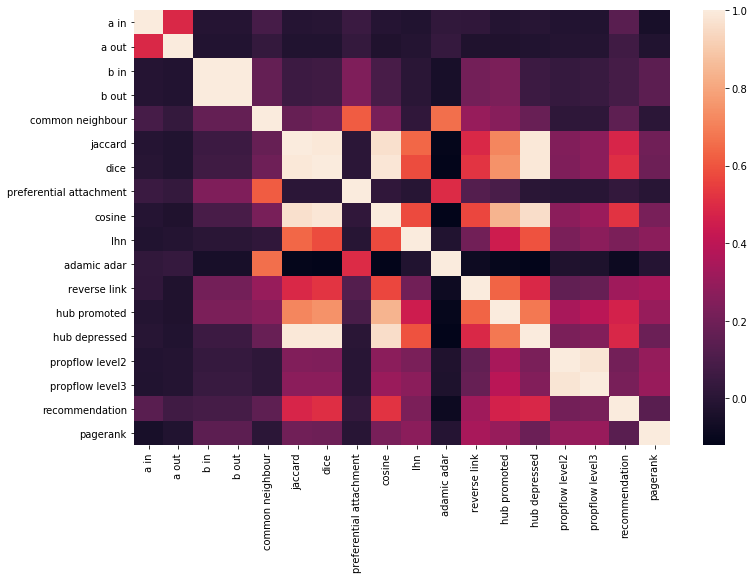

In [40]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,8)
df = pd.DataFrame(X_train, columns=['a in','a out','b in','b out',
          'common neighbour','jaccard','dice','preferential attachment','cosine',
          'lhn','adamic adar','reverse link','hub promoted','hub depressed',
          'propflow level2','propflow level3','recommendation','pagerank'])
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [3]:
mean = np.mean(X_train, axis=0, keepdims=True)
std = np.std(X_train, axis=0, keepdims=True)
Xn_train = (X_train - mean) / std
Xn_test = (X_test - mean) / std

In [4]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


0.8725


In [5]:
rf.feature_importances_

array([0.06947524, 0.08564339, 0.07261427, 0.07263143, 0.00207801,
       0.00594526, 0.00529761, 0.00544126, 0.01055582, 0.00864583,
       0.00167742, 0.00708795, 0.01353022, 0.00393792, 0.06661917,
       0.08203357, 0.28266216, 0.20412345])

In [ ]:
base = RandomForestClassifier(n_estimators=100)
parameters = {
    "max_depth":[9,11,13,15,17],
    "min_samples_leaf":[1,3,5],
    "min_samples_split":[2,4,6,8,10],
}
model = GridSearchCV(base, parameters, n_jobs=-1)
model.fit(Xn_train, y_train)
print(model.score(Xn_test, y_test))

In [ ]:
print(roc_auc_score(y_test, np.squeeze(model.predict_proba(Xn_test)[:,1])))

In [ ]:
(model.predict(X_test) == 0).sum()

In [ ]:
model.best_estimator_

In [ ]:
model.best_estimator_.feature_importances_

## prepare submission

In [ ]:
with open("test-public.txt","r") as f:
    test = f.readlines()

X_t = []
for l in test[1:]:
    temp = list(map(int, l.split()))
    X_t.append([temp[1], temp[2]])
print(len(X_t))

In [ ]:
X_t = np.array(feature_generator(X_t))

In [ ]:
X_t.dump("Xt.npy")

In [10]:
X_t = np.load("Xt_.npy")

with open("rec_sim_test.pickle", "rb") as f:
    rec_sim_test = pickle.load(f)

with open("pagerank_test.pickle","rb") as f:
    pr_t = pickle.load(f)
#with open("amp_test.pickle","rb") as f:
#    amp_t = pickle.load(f)

In [11]:
X_t = X_t[:, :-1].tolist()

for i in range(len(X_t)):
    X_t[i].append(rec_sim_test[i+1])

for i in range(len(X_t)):
    X_t[i].append(pr_t[i])
#for i in range(len(X_t)):
#    X_t[i].append(amp_t[i])

X_t = np.array(X_t)
#Xn_t = (X_t - mean) / std
print(X_t.shape)

(2000, 18)


In [ ]:
y_pred = model.predict(X_t)
(y_pred == 0).sum()

In [ ]:
y_pred_prob = model.predict_proba(X_t)

In [ ]:
with open("pred_rf.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

## xgboost

In [12]:
import xgboost

In [14]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
print(roc_auc_score(y_test, np.squeeze(xgb.predict_proba(X_test)[:,1])))

0.9616384616384616


In [15]:
y_pred = xgb.predict(X_t)
(y_pred == 0).sum()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1218

In [16]:
y_pred_prob = xgb.predict_proba(X_t)

with open("pred.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

In [19]:
params = {"learning_rate":[0.01,0.03,0.05,0.1],
          "max_depth":[4,6,8],
          "subsample":[0.6,0.75,0.85,1],
          "colsample_bylevel":[0.6,0.75,0.85,1]}

base = xgboost.XGBClassifier(n_estimators=200,booster="gbtree")
xgb_ = GridSearchCV(base,params,n_jobs=-1,scoring='roc_auc',verbose=1)
xgb_.fit(X_train, y_train)
print("done!")

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  7.3min finished


done!


In [20]:
xgb_.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [21]:
scores = xgb_.best_estimator_.get_booster().get_score()
print(scores)

fnames = ['a in','a out','b in','b out',
          'common neighbour','jaccard','dice','preferential attachment','cosine',
          'lhn','adamic adar','reverse link','hub promoted','hub depressed',
          'propflow level2','propflow level3','recommendation','pagerank']

mapped = {fnames[int(k[1:])]: v for k, v in scores.items()}
print(mapped)

{'f16': 425, 'f17': 525, 'f2': 394, 'f1': 307, 'f15': 273, 'f7': 67, 'f10': 11, 'f14': 153, 'f0': 280, 'f4': 3, 'f3': 66, 'f11': 19, 'f5': 5, 'f9': 5, 'f12': 7, 'f13': 1, 'f8': 1}
{'recommendation': 425, 'pagerank': 525, 'b in': 394, 'a out': 307, 'propflow level3': 273, 'preferential attachment': 67, 'adamic adar': 11, 'propflow level2': 153, 'a in': 280, 'common neighbour': 3, 'b out': 66, 'reverse link': 19, 'jaccard': 5, 'lhn': 5, 'hub promoted': 7, 'hub depressed': 1, 'cosine': 1}


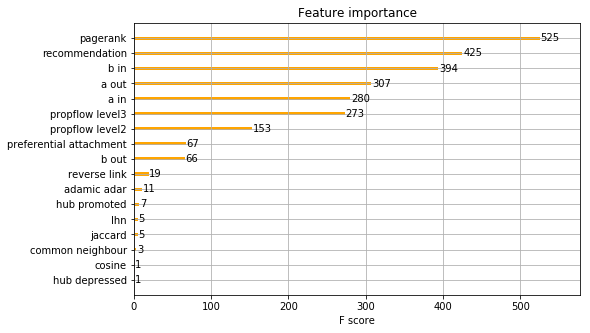

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
ax = xgboost.plot_importance(mapped,importance_type="weight",ylabel=None,color="orange")
plt.show()

In [28]:
y_pred = xgb_.predict(X_test)
(y_pred == 0).sum()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


2101

In [29]:
print(roc_auc_score(y_test, np.squeeze(xgb_.predict_proba(X_test)[:,1])))

0.9632604632604632


Confusion matrix, without normalization
[[1836  162]
 [ 265 1737]]


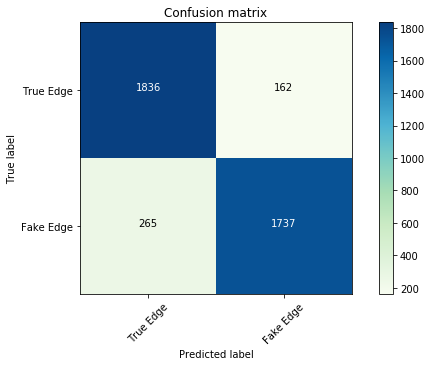

In [30]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,cmap=plt.cm.GnBu)
plt.show()

In [32]:
y_pred_prob = xgb_.predict_proba(X_t)
with open("pred_xg.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

## lightgbm

In [5]:
import lightgbm

In [85]:
gbm = lightgbm.LGBMClassifier(boosting_type='rf',bagging_freq=1,bagging_fraction=0.75,feature_fraction=0.75,n_estimators=100)
gbm.fit(Xn_train, y_train)
print(roc_auc_score(y_test, np.squeeze(gbm.predict_proba(Xn_test)[:,1])))

0.9362866068606227


In [81]:
params = {"bagging_fraction":[0.25,0.5,0.75],
          "feature_fraction":[0.25,0.5,0.75],
          "num_leaves":[20,30,40]}

base = lightgbm.LGBMClassifier(boosting_type='rf',bagging_freq=1)
gbm_rf = GridSearchCV(base,params,n_jobs=-1,scoring='roc_auc',verbose=1)
gbm_rf.fit(Xn_train, y_train)
print(roc_auc_score(y_test, np.squeeze(gbm_.predict_proba(Xn_test)[:,1])))
gbm_rf.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   20.6s finished


0.9463437403718804


LGBMClassifier(bagging_fraction=0.75, bagging_freq=1, boosting_type='rf',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.75,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [77]:
params = {"learning_rate":[0.03,0.05,0.1,0.15],
          "max_depth":[4,6,8,10,-1],
          "subsample":[0.5,0.6,0.75,0.85,1],
          "min_child_samples":[5,10,20],
          "num_leaves":[20,30,40]}

base = lightgbm.LGBMClassifier(boosting_type='dart',n_estimators=200,verbose=-1)
gbm_ = GridSearchCV(base,params,n_jobs=-1,scoring='roc_auc',verbose=1)
gbm_.fit(Xn_train, y_train)
print("done!")

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 27.8min finished


done!


In [78]:
gbm_.best_estimator_

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.15, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=20, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
        subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [79]:
print(roc_auc_score(y_test, np.squeeze(gbm_.predict_proba(Xn_test)[:,1])))

0.9463437403718804


In [ ]:
y_pred_prob = gbm_.predict_proba(Xn_t)
with open("pred_light.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

## tests

In [19]:
from sklearn.svm import SVC

params = {"C":[3,5,7],
          "degree":[2,3,4],
          "coef0":[0,1]}

base = SVC(probability=True, kernel="poly")

svm = GridSearchCV(base,params,n_jobs=-1,scoring='roc_auc',verbose=1)
svm.fit(Xn_train, y_train)
print(roc_auc_score(y_test, np.squeeze(svm.predict_proba(Xn_test)[:,1])))
svm.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  7.8min finished


0.8761372434668833


SVC(C=7, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=4, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
from sklearn.tree import ExtraTreeClassifier

params = {"splitter":["best","random"],
          "min_samples_split":[18,20,22,24,26]}

base = ExtraTreeClassifier()

extra = GridSearchCV(base,params,n_jobs=-1,scoring='roc_auc',verbose=1)
extra.fit(Xn_train, y_train)
print(roc_auc_score(y_test, np.squeeze(extra.predict_proba(Xn_test)[:,1])))
extra.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished


0.8974388952020453


ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=22,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(Xn_train, y_train)
print(roc_auc_score(y_test, np.squeeze(knn.predict_proba(Xn_test)[:,1])))

0.9023499863955922


In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100)
lr.fit(Xn_train, y_train)
print(roc_auc_score(y_test, np.squeeze(lr.predict_proba(Xn_test)[:,1])))

0.8522685099972391


In [58]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.5)
ada.fit(Xn_train, y_train)
print(roc_auc_score(y_test, np.squeeze(ada.predict_proba(Xn_test)[:,1])))

0.9242953466923283


In [41]:
np.mean(X_train, axis=0)

array([ 9.31212500e+01,  1.21161919e+03,  1.45655875e+02,  1.45655875e+02,
        4.26712500e+00,  6.62738122e-03,  5.87533818e-03,  4.56837890e+05,
        1.41441464e-02,  2.69055537e-04, -5.10308193e+00,  7.64375000e-02,
        3.06508862e-02,  8.83518307e-03,  3.51642942e-04,  4.23161857e-04,
        9.83753780e-02,  3.77080285e-03])

In [42]:
np.mean(X_t, axis=0)

array([9.09115000e+01, 1.32304800e+03, 1.43195000e+02, 1.43195000e+02,
       5.61900000e+00, 6.99230447e-03, 6.13110877e-03, 7.96449188e+05,
       1.44146682e-02, 3.11763492e-04, 1.89884162e+00, 7.80000000e-02,
       2.91902817e-02, 9.36588973e-03, 2.29779200e-04, 2.62827332e-04,
       9.76152658e-02, 5.85421565e-04])